In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

from src.features import remove_outliers
from src.models.PhysicalModel import PhysicalModel
from src.models.BehaviourTransformer import BehaviourTransformer


rc = {
    "font.sans-serif": ["Fira Sans Condensed", "Arial"],
    "lines.linewidth": 2.5,
    "axes.grid": True,
    "axes.grid.axis": "y",
    "grid.linewidth": 1.5,
    "axes.titleweight": "bold",
    "axes.titlelocation": "left",
    "legend.edgecolor": "none",
    "legend.title_fontsize": 0,
    "xtick.bottom": True,
    "axes.edgecolor": ".15",
    "figure.figsize": [8.0, 5.0],
    "axes.spines.bottom": True,
    "axes.spines.left": False,
    "axes.spines.right": False,
    "axes.spines.top": False,
}
sns.set_theme( 
    style="whitegrid",
    context="talk",
    rc=rc
)

pd.set_option('display.max_columns', None)

In [2]:
# from src.features import load_trips
# temp = load_trips(['M3_VH', 'M3_HH', 'CPH1_HH', 'CPH1_VH', 'CPH6_VH', 'CPH6_HH'], trips='all', sampling='1s')
# temp.to_parquet("../data/processed/all_trips.parquet")
# del temp

In [3]:
all_data = pd.read_parquet("../data/processed/all_trips.parquet")
# df = all_data.query("route in ['M3_VH', 'CPH1_HH', 'CPH1_VH']")
# df_test = all_data.query("route in ['CPH6_VH', 'CPH6_HH']")
df = all_data.query("route == 'CPH1_VH' and trip in [7792, 7805, 8040, 8042, 8227, 9289]")
df_test = all_data.query("route == 'CPH1_VH' and trip == 10218")

outlier_columns = ['acceleration_z',
                   'acceleration_y',
                   'acceleration_x',
                   'steering_position',
                   'steering_acceleration',
                   'traction_instant_consumption',
                   'yaw_rate',
                   'velocity']

df = remove_outliers(df, outlier_columns)
df = df.sort_index()


# df_test = remove_outliers(df_test, outlier_columns)
# df_test = df_test.sort_index()

In [4]:
features_road = ["traffic_lights", "road_signs", "speed_limit", "ped_walks", "speed_bumps", "bike_lane"]

In [5]:
behaviour_transformer = BehaviourTransformer()

df = df.merge(behaviour_transformer.adjust_acceleration(df, columns=["acceleration_x", "acceleration_y"]), 
                    left_index=True, right_index=True)

df = df.reset_index().drop_duplicates('TS_or_Distance').set_index('TS_or_Distance')

behaviour_transformer.fit(df)

physical_model = PhysicalModel()
physical_model.fit("velocity", "acceleration_y")

df = df.merge(behaviour_transformer.transform(df), left_index=True, right_index=True)\
             .assign(kW_pred=physical_model.predict(df))\
             .assign(error=lambda x: x.kW_pred - x.traction_instant_consumption)

In [6]:
df_test = df_test[~df_test.index.duplicated(keep='first')]
df_test.loc[:, features_road] = df_test[features_road].fillna(0)
df_test = df_test.dropna(how='any', axis=0)

df_test = df_test.merge(behaviour_transformer.adjust_acceleration(df_test, columns=["acceleration_x", "acceleration_y"]), 
                    left_index=True, right_index=True)

physical_model = PhysicalModel()
physical_model.fit("velocity", "acceleration_y")

df_test = df_test.merge(behaviour_transformer.transform(df_test), left_index=True, right_index=True)\
                            .assign(kW_pred=physical_model.predict(df_test))\
                            .assign(error=lambda x: x.kW_pred - x.traction_instant_consumption)

In [7]:
features = ['adjusted_acceleration_x', 'adjusted_acceleration_y', 'yaw_rate', 'velocity'] \
    + ['driver_safety_belt_reminder'] \
    + behaviour_transformer.behavioural_columns \
    + features_road \
    + behaviour_transformer.var_cols
target = "error"

In [8]:
# from sklearn.model_selection import GridSearchCV
# import lightgbm as lgb

# def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
#                        model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
#                        do_probabilities = False):
#     gs = GridSearchCV(
#         estimator=model,
#         param_grid=param_grid, 
#         cv=cv, 
#         n_jobs=-1, 
#         scoring=scoring_fit,
#         verbose=2
#     )
#     fitted_model = gs.fit(X_train_data, y_train_data)
    
#     if do_probabilities:
#       pred = fitted_model.predict_proba(X_test_data)
#     else:
#       pred = fitted_model.predict(X_test_data)
    
#     return fitted_model, pred

# model = lgb.LGBMRegressor()
# param_grid = {
#     'n_estimators': [50, 100, 150],
#     'colsample_bytree': [0.7, 0.8, 0.9, 1.],
#     'max_depth': [15,20,25],
#     'num_leaves': [20, 30, 40, 50, 60],
#     # 'reg_alpha': [1.1, 1.2, 1.3],
#     # 'reg_lambda': [1.1, 1.2, 1.3],
#     # 'min_split_gain': [0.3, 0.4],
#     # 'subsample': [0.7, 0.8, 0.9],
#     # 'subsample_freq': [20]
# }

# df_cv = df[features + [target]].dropna(axis=0)
# df_test_cv = df_test[features + [target]].dropna(axis=0)
# cv, pred = algorithm_pipeline(df_cv[features].to_numpy(), df_test_cv[features].to_numpy(), df_cv[target].to_numpy(), df_test_cv[target].to_numpy(), model, 
#                                  param_grid, cv=5)

# print(cv.best_score_)
# print(cv.best_params_)

# model = cv.best_estimator_

In [9]:
import lightgbm as lgb
model = lgb.LGBMRegressor()
model.fit(df[features], df[target])

LGBMRegressor()

# Testing

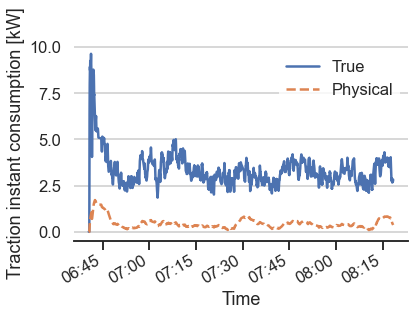

In [10]:
df_plot = df_test.query("`trip` == 10218").drop(["route"], axis=1).rolling("5min").mean().reset_index()

fig, ax = plt.subplots()
sns.lineplot(data=df_plot, x="TS_or_Distance", y="traction_instant_consumption", label='True', ax=ax)
sns.lineplot(data=df_plot, x="TS_or_Distance", y="kW_pred", label='Physical', linestyle='--', ax=ax)

ax.set(
    # title="Physical model prediction on test set",
    xlabel="Time",
    ylabel="Traction instant consumption [kW]",
)
fig.autofmt_xdate()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.savefig("../figures/physical_test.pdf")

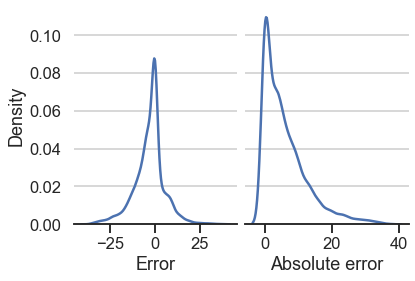

In [11]:
fig, ax = plt.subplots(ncols=2, sharey=True)
sns.kdeplot(x=df_test.error, ax=ax[0])
sns.kdeplot(x=df_test.error.abs(), ax=ax[1])
ax[0].set(
    xlabel="Error",
)
ax[1].set(
    xlabel="Absolute error",
)
fig.subplots_adjust(wspace=0.05, hspace=0)
fig.savefig("../figures/physical_error.pdf")

In [12]:
df['error_pred'] = model.predict(df[features])
df['kW_pred_final'] = df['kW_pred'] - df['error_pred']


df_test['error_pred'] = model.predict(df_test[features])
df_test['kW_pred_final'] = df_test['kW_pred'] - df_test['error_pred']


# df_test['kW_pred_final'] = model.predict(df_test[features])

In [13]:
from sklearn.metrics import r2_score

print(r2_score(df['traction_instant_consumption'], df['kW_pred_final']))
print(r2_score(df_test['traction_instant_consumption'], df_test['kW_pred_final']))

0.7118736119864251
0.6636506627919361


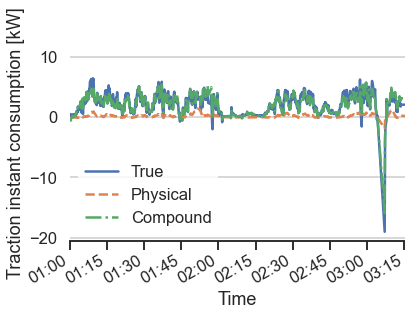

In [14]:
df_plot = df.query("`trip` == 7792").drop(["route"], axis=1).rolling("2min").mean().reset_index()

fig, ax = plt.subplots()
sns.lineplot(data=df_plot, x="TS_or_Distance", y="traction_instant_consumption", label='True')
sns.lineplot(data=df_plot, x="TS_or_Distance", y="kW_pred", label='Physical', linestyle='--')
sns.lineplot(data=df_plot, x="TS_or_Distance", y="kW_pred_final", label='Compound', linestyle='dashdot')

ax.set(
    # title='Physical and compound model predictions on train set',
    xlabel="Time",
    ylabel="Traction instant consumption [kW]",
    xlim=[datetime(2021, 4, 22, 1, 0, 0), datetime(2021, 4, 22, 3, 15, 0)]
)
fig.autofmt_xdate()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.savefig("../figures/compound_train.pdf")

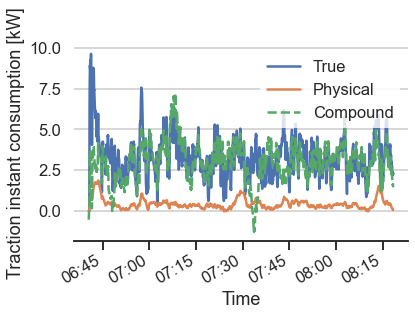

In [15]:
df_plot = df_test.query("`trip` == 10218").drop(["route"], axis=1).rolling("2min").mean().reset_index()

fig, ax = plt.subplots()
sns.lineplot(data=df_plot, x="TS_or_Distance", y="traction_instant_consumption", label='True')
sns.lineplot(data=df_plot, x="TS_or_Distance", y="kW_pred", label='Physical')
sns.lineplot(data=df_plot, x="TS_or_Distance", y="kW_pred_final", label='Compound', linestyle='--')

ax.set(
    # title='Physical and compound model predictions on test set',
    xlabel="Time",
    ylabel="Traction instant consumption [kW]",
)
fig.autofmt_xdate()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.savefig("../figures/compound_test.pdf")

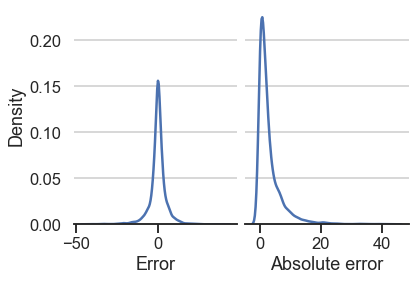

In [16]:
fig, ax = plt.subplots(ncols=2, sharey=True)
sns.kdeplot(x=df_test.assign(error=lambda x: x.kW_pred_final - x.traction_instant_consumption).error, ax=ax[0])
sns.kdeplot(x=df_test.assign(error=lambda x: x.kW_pred_final - x.traction_instant_consumption).error.abs(), ax=ax[1])
ax[0].set(
    xlabel="Error",
)
ax[1].set(
    xlabel="Absolute error",
)
fig.subplots_adjust(wspace=0.05, hspace=0)
fig.savefig("../figures/compound_error.pdf")

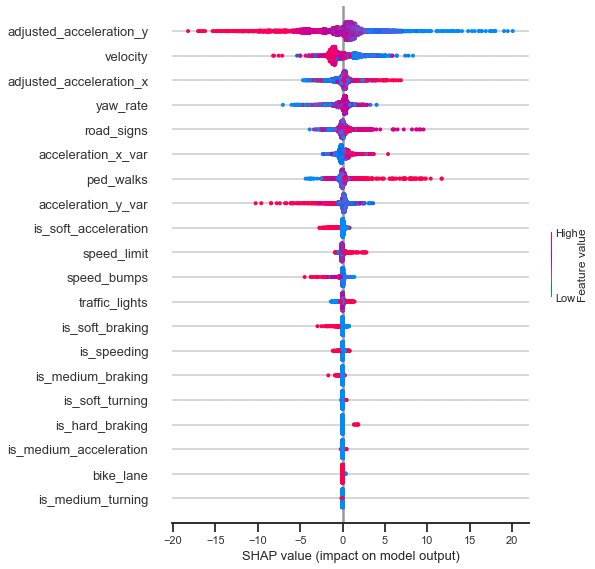

In [17]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df_test[features])

shap.summary_plot(shap_values, df_test[features])